# **Imports**

In [1]:
from gloess import gloess
from catalog_filter import box
from cmdtools import gen_CMD, gen_CMD_xcut, gen_CMD_ycut, running_avg
import photutils as phot
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, LocalBackground

In [2]:
import sys
import time
import json
import numpy as np
import pandas as pd
from glob import glob
import urllib.request
import tarfile
import os
import itertools

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.wcs import WCS
from astropy.modeling import models, fitting, custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky, angular_separation
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.nddata.utils import Cutout2D
from astropy.coordinates.matrix_utilities import rotation_matrix

import photutils as phot
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, LocalBackground
from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder, GriddedPSFModel
from photutils.psf import SourceGrouper, extract_stars, IterativePSFPhotometry, DAOPhotPSFPhotometry

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, EllipticalAperture

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from scipy.ndimage import sobel, gaussian_filter, convolve
from scipy.signal import savgol_filter
from astropy.stats.biweight import biweight_location, biweight_midvariance,biweight_scale
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import find_peaks
from spectral_cube import SpectralCube
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization.wcsaxes import SphericalCircle

In [3]:
from reproject import reproject_exact
from reproject.mosaicking import find_optimal_celestial_wcs

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as col
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
import seaborn as sb
import matplotlib.gridspec as gridspec
sb.set_style('white')
from matplotlib.ticker import (MultipleLocator, AutoLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 35
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 35

font1 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '15'}
font2 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '25'}

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


In [6]:
import multiprocessing as mp

# **MUSE**

In [7]:
muse_cube = fits.open('../data/MUSE/NGC0628_MAPS_native.fits')

In [8]:
ha = muse_cube[30].data
ha_err = muse_cube[31].data
muse_wcs = WCS(muse_cube[30].header)

# **UVIT**

In [9]:
fs = glob('../data/UVIT/2023/*')

In [10]:
uv_data_dict = {}
for f in fs:
    hdu = fits.open(f)[0]
    uv_data_dict[f.split('_')[1]] = {'data':hdu.data,
                                       'wcs': WCS(hdu.header)}

In [11]:
uv_data_dict.keys()

dict_keys(['F148', 'F154', 'F169', 'F172', 'N219', 'N242', 'N245', 'N263', 'N279'])

In [12]:
uv_data = uv_data_dict['F148']['data']
uv_data += uv_data_dict['F154']['data']
uv_data += uv_data_dict['F169']['data']
uv_data += uv_data_dict['F172']['data']
uv_data += uv_data_dict['N219']['data']
uv_data += uv_data_dict['N242']['data']
uv_data += uv_data_dict['N245']['data']
uv_data += uv_data_dict['N263']['data']
uv_data += uv_data_dict['N279']['data']

kernel = Gaussian2DKernel(3, x_size=3, y_size=3)
uv_data = convolve(uv_data, kernel)

uv_wcs = uv_data_dict['F154']['wcs']

mmm_bkg = MMMBackground()

sigma_clip = SigmaClip(3)
    
bkg = Background2D(uv_data, (64, 64),
                  filter_size=(3, 3),
                  sigma_clip=sigma_clip,
                  bkg_estimator=mmm_bkg)

bkg_mask = (uv_data>=3*bkg.background_rms)
bkg_mask = np.where(bkg_mask, 1, np.nan)
bkg_mask_inv = np.where(bkg_mask, np.nan,1)

In [13]:
ha_r,_ = reproject_exact((ha,muse_wcs),output_projection=uv_wcs)
ha_err_r,_ = reproject_exact((ha_err,muse_wcs),output_projection=uv_wcs)

In [14]:
ha_min = 6*ha_err_r

ha_fin = np.where(ha_r<ha_min,ha_min,ha_r)
ha_mask = np.where(ha_r<ha_min,1,np.nan)
ha_mask_inv = np.where(ha_r<ha_min,np.nan,1)

In [15]:
uv_ha = (uv_data/ha_fin)

(1750.0, 2500.0)

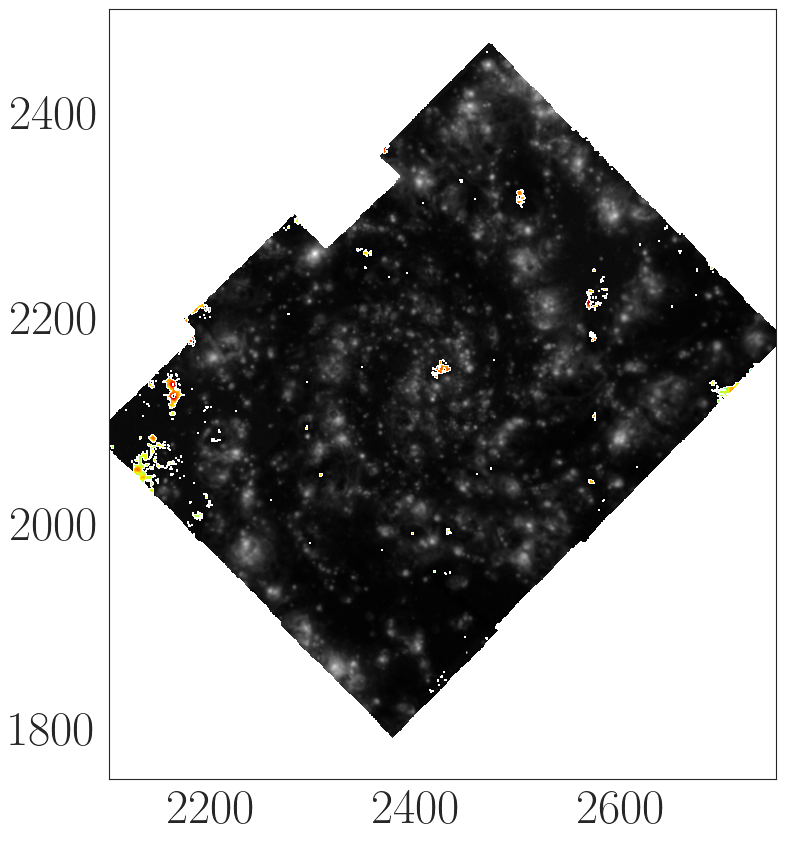

In [16]:
fig = plt.figure(figsize=(10,10))
inv_mask = np.where(np.isnan(ha_mask*bkg_mask),1,np.nan)

data = uv_data*ha_mask*bkg_mask
norm = simple_norm(data,'log')
ax = fig.add_subplot(111)
ax.imshow(data,norm=norm, cmap='jet')

inv_mask = np.where(np.isnan(ha_mask*bkg_mask),1,np.nan)
data = ha_fin
norm = simple_norm(data,'log')
ax.imshow(data*inv_mask,norm=norm, cmap='gist_gray')

ax.set_xlim(2100,2750)
ax.set_ylim(1750,2500)

In [1]:
data = uv_data*ha_mask*bkg_mask
header = uv_wcs.to_header()

NameError: name 'uv_data' is not defined

In [ ]:
l = 24/ps

# **HST and JWST**

In [8]:
Av_dict = { 
            'f275w': 2.02499,
            'f336w': 1.67536,
            'f435w': 1.33879,
            'f555w': 1.03065,
            'f814w': 0.59696,
    
            'f090w': 0.583,
            'f115w': 0.419,
            'f150w': 0.287,
            'f200w': 0.195,
    
            'f438w': 1.34148,
            'f606w': 0.90941,
            'f814w': 0.59845
          }

In [9]:
df_cmd_jwst = pd.read_csv("../data/isochrones_master/cmd_jwst.csv")
df_cmd_acs = pd.read_csv("../data/isochrones_master/cmd_hst_acs.csv")

In [10]:
regions_dict = {'bubble' : {'ra'   : 24.1858128,  
                       'dec'  : 15.7725802,
                       'F115W': 25.4, 
                       'F150W': 24.63,
                       'F200W': 23.53,
                      
                       'F435W': 27.88, 
                       'F555W': 27.48,
                       'F814W': 26.52},
                
            'ngc628' : {'ra'   : 24.1738983, 
                       'dec'  : 15.7836543,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56},
            'm83' :   {'ra'   : 204.2536827 ,  
                       'dec'  : -29.8655432,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56},
            'm51' :  {'ra'   : 202.4696435,
                       'dec'  : 47.1952141,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56},   
           }
                             
            
with open('regions90_ngc628.json') as json_file:
    data = json.load(json_file)
    
regions_dict.update(data)

with open('../data/DS9 regions/bubbles.reg') as f:
    dat = f.readlines()
    
bubbles = {}
for n,i in enumerate(dat[3:]):
    ra = float(i.split(',')[0][7:])
    dec = float(i.split(',')[1])
    radius = float(i.split(',')[2].split('"')[0])
    bubbles[f'bubble_{n}'] = {'ra' : ra,
                              'dec': dec,
                              'radius': radius}
regions_dict.update(bubbles) ;


with open('../data/DS9 regions/bubbles_m51.reg') as f:
    dat = f.readlines()
    
m51_bubbles = {}
p = 0
for n,i in enumerate(dat[3:]):
    ra = float(i.split(',')[0][8:])
    dec = float(i.split(',')[1])
    a = float(i.split(',')[2][:-1])
    b = float(i.split(',')[3][:-1])
    ang = float(i.split(',')[4].split(')')[0])
    
    radius = float(i.split(',')[2].split('"')[0])
    
    if (a>2) and (b>2):
        m51_bubbles[f'bubble_m51_{p}'] = {'ra' : ra,
                                      'dec': dec,
                                      'a'  : a,
                                      'b'  : b,
                                      'ang':ang}
        p +=1
        
regions_dict.update(m51_bubbles) ;


In [11]:
ages_ = [6.8,7,7.2, 7.5,7.8,8,8.2,8.5,8.8,9,9.6,10]

ages_y = [6.8, 7.0,7.3,7.6,7.8,8,8.5,8.8]
ages_o = [9.0, 9.6,10]

mag_err_lim = 0.2

In [15]:
#tab['col']  = tab['mag_vega_F115W'] - tab['mag_vega_F200W']

#tab = tab[tab['mag_vega_F200W']<-10*(tab['col'] -1.3) + 20]

#tab = tab[tab['mag_vega_F200W']<-10*(tab['col'] -1.6) + 20]

#tab = tab[tab['mag_vega_F200W']<20.75]

## **NGC-628**

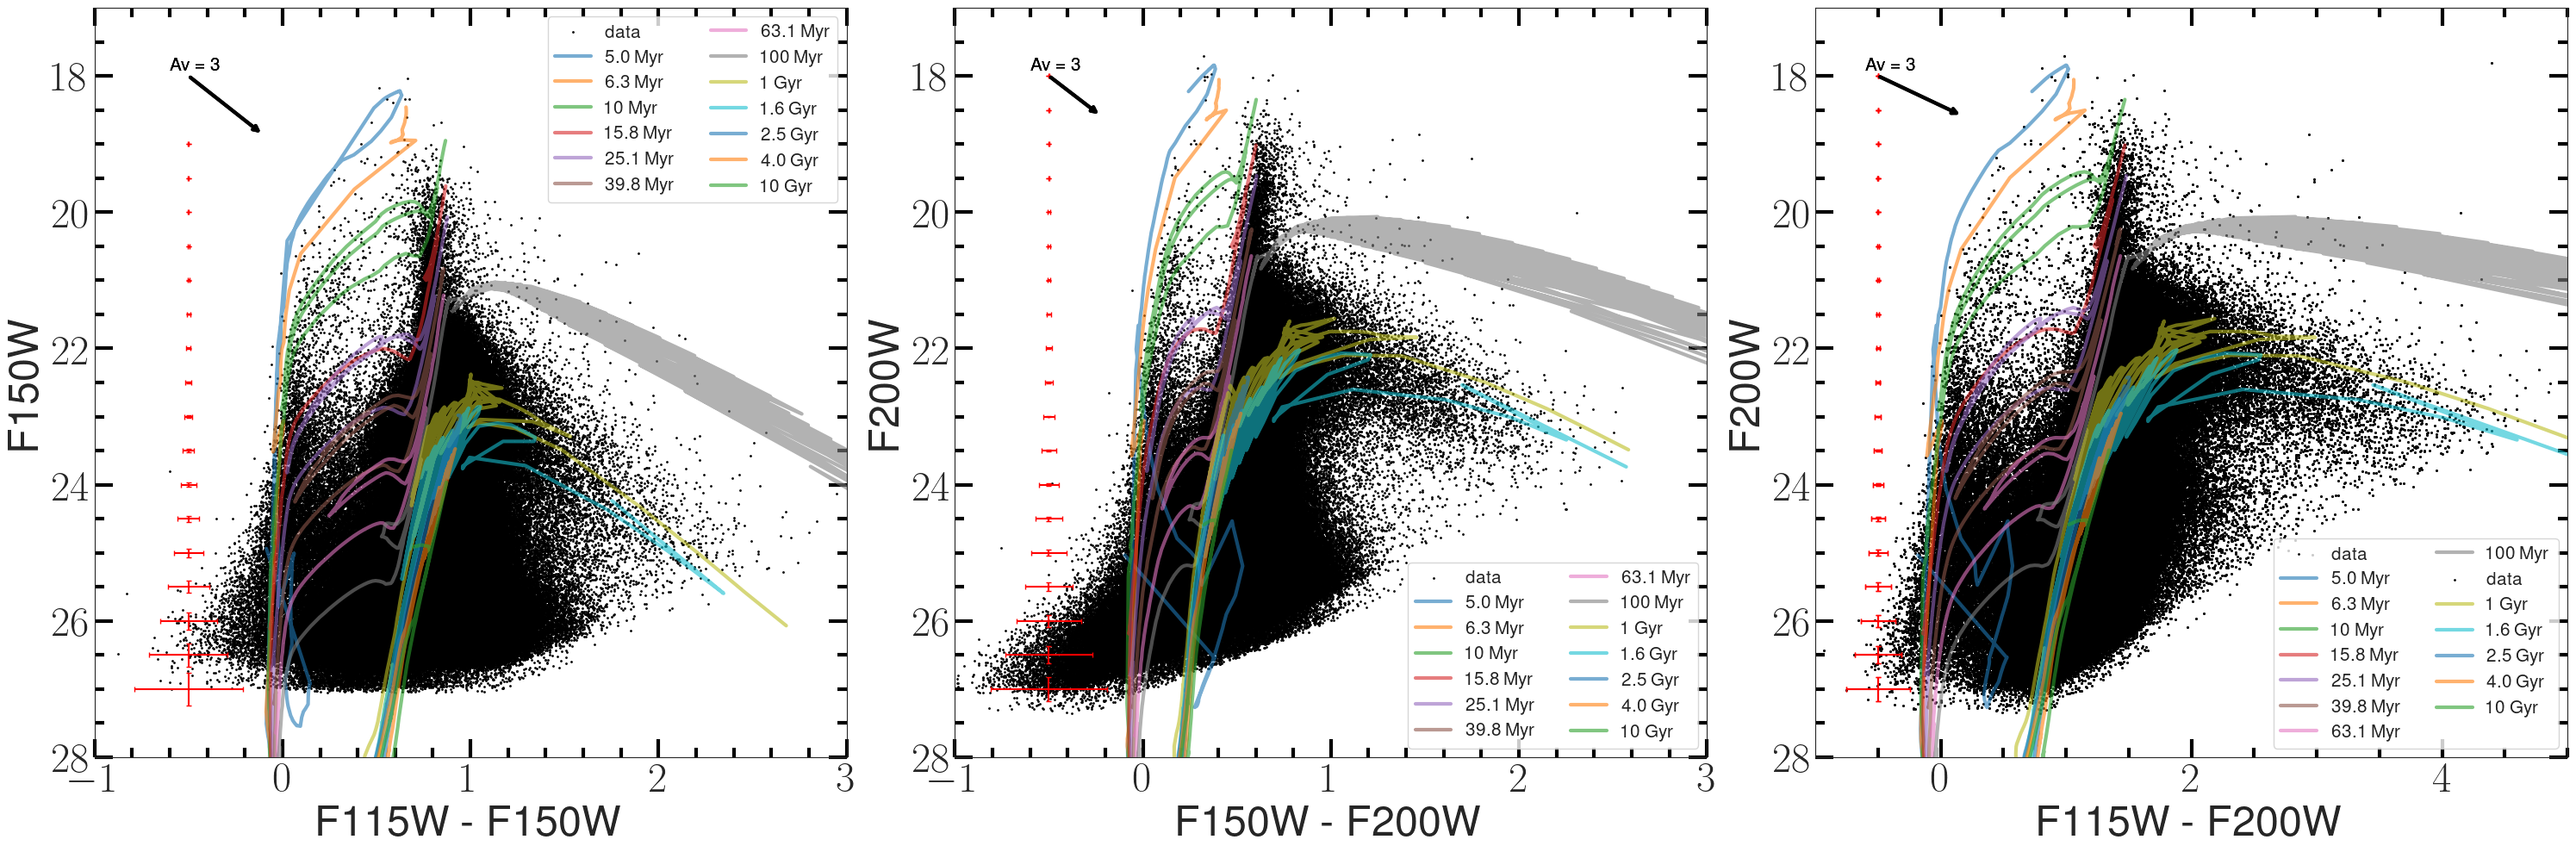

In [13]:
tab = Table.read('../photometry/ngc628/f115w_f150w_f200w_photometry.fits')

fig, ax = plt.subplots(1,3,figsize=(30,10))
ra_cen = regions_dict['ngc628']['ra']
dec_cen = regions_dict['ngc628']['dec']

filters = {'filt1':'f115w',
           'filt2':'f150w',
           'filt3':'f150w'}

positions = {'ra_col': 'ra',
             'dec_col' : 'dec',
             'ra_cen': ra_cen,
             'dec_cen': dec_cen}

region = {'r_in':0,
          'r_out': 2000,#:data['radius'],
          'spatial_filter': 'circle'}

extinction = {'Av': 0.19,
              'Av_x': -0.5,
              'Av_y': 18,
              'Av_': 3}

axis_limits= {'xlims': [-1, 3], 
              'ylims': [17, 28]}

isochrone_params={'met': [0.02],
                  'label_min': 1,
                  'label_max': 10,
                  'ages': [6.7,6.8,7,7.2,7.4,7.6,7.8,8]}

error_settings = {'ref_xpos': -0.5,
                  'mag_err_lim':0.2}

plot_settings = {'s':1, 'legend.ncols':2, 'alpha':0.6}

fig,_, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.81,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': False},
                      fig=fig, ax=ax[0])

isochrone_params['ages'] = [9,9.2,9.4,9.6,10]
isochrone_params['met'] = [0.002]

fig,_, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.81,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': True},
                      fig=fig, ax=ax[0])

filters = {'filt1':'f150w',
           'filt2':'f200w',
           'filt3':'f200w'}

isochrone_params['ages'] = [6.7,6.8,7,7.2,7.4,7.6,7.8,8]
isochrone_params['met'] = [0.02]

axis_limits= {'xlims': [-1, 3], 
              'ylims': [17, 28]}

extinction = {'Av': 0.19,
              'Av_x': -0.5,
              'Av_y': 18,
              'Av_': 3}

error_settings = {'ref_xpos': -0.5,
                  'mag_err_lim':0.2}

fig,_, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.81,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': False},
                      fig=fig, ax=ax[1])

isochrone_params['ages'] = [9,9.2,9.4,9.6,10]
isochrone_params['met'] = [0.002]

fig,_, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.81,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': True},
                      fig=fig, ax=ax[1])

filters = {'filt1':'f115w',
           'filt2':'f200w',
           'filt3':'f200w'}

isochrone_params['ages'] = [6.7,6.8,7,7.2,7.4,7.6,7.8,8]
isochrone_params['met'] = [0.02]

axis_limits= {'xlims': [-1, 5], 
              'ylims': [17, 28]}

extinction = {'Av': 0.19,
              'Av_x': -0.5,
              'Av_y': 18,
              'Av_': 3}

error_settings = {'ref_xpos': -0.5,
                  'mag_err_lim':0.2}

fig,_, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.81,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': False},
                      fig=fig, ax=ax[2])

isochrone_params['ages'] = [9,9.2,9.4,9.6,10]
isochrone_params['met'] = [0.002]
positions = {'ra_col': 'ra',
             'dec_col' : 'dec',
             'ra_cen': ra_cen,
             'dec_cen': dec_cen}

region = {'r_in':0,
          'r_out': 2000,#:data['radius'],
          'spatial_filter': 'circle'}

fig,_, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.81,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': False},
                      fig=fig, ax=ax[2])

for a in ax:
    a.tick_params(which='both', length=15,direction="in", right=True, width = 3,
                   color="black")
    
    a.tick_params(which='minor', length=8, width = 3, color="black")
    a.xaxis.set_minor_locator(AutoMinorLocator())
    a.yaxis.set_minor_locator(AutoMinorLocator())
    a.yaxis.set_major_locator(AutoLocator())
    a.yaxis.set_minor_locator(AutoMinorLocator())

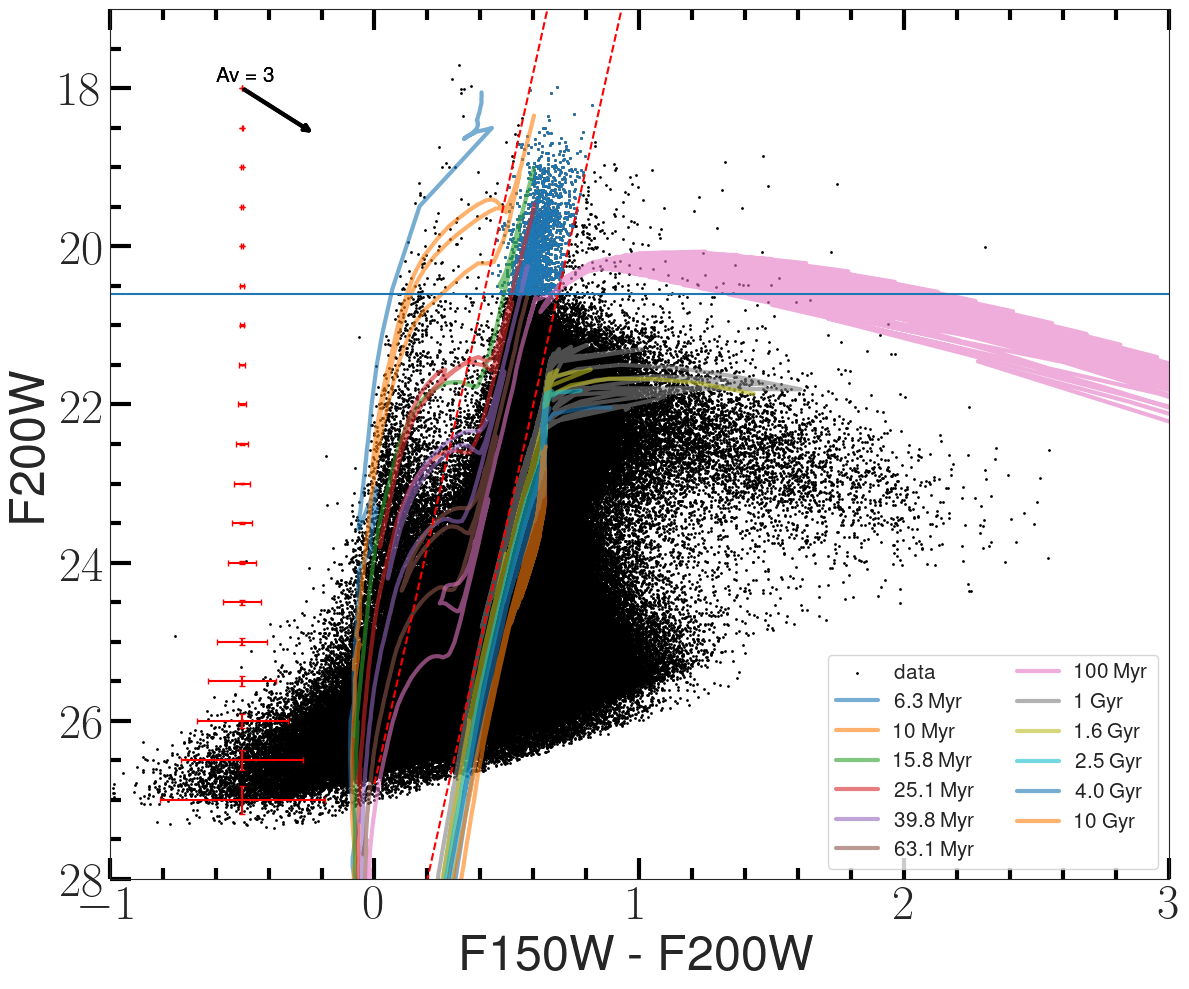

In [16]:
tab = Table.read('../photometry/ngc628/f115w_f150w_f200w_photometry.fits')

ra_cen = regions_dict['ngc628']['ra']
dec_cen = regions_dict['ngc628']['dec']

filters = {'filt1':'f150w',
           'filt2':'f200w',
           'filt3':'f200w'}

positions = {'ra_col': 'ra',
             'dec_col' : 'dec',
             'ra_cen': ra_cen,
             'dec_cen': dec_cen}

isochrone_params={'met': [0.02],
                  'label_min': 0,
                  'label_max': 10,
                  'ages': [6.8,7,7.2,7.4,7.6,7.8,8]}


region = {'r_in':0,
          'r_out': 2000,#:data['radius'],
          'spatial_filter': 'circle'}

error_settings = {'ref_xpos': -0.5,
                  'mag_err_lim':0.2}

plot_settings = {'s':1, 'legend.ncols':2, 'alpha':0.6}


axis_limits= {'xlims': [-1, 3], 
              'ylims': [17, 28]}

extinction = {'Av': 0.19,
              'Av_x': -0.5,
              'Av_y': 18,
              'Av_': 3}

fig,ax, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.81,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': False})

isochrone_params['ages'] = [9,9.2,9.4,9.6,10]
isochrone_params['met'] = [0.02]

fig,ax, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.81,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': True},
                      fig=fig, ax=ax)

x = np.linspace(0,1)
y = -15*(x-0.52) + 19

ax.plot(x,y,'--r')

x = np.linspace(0,1)
y = -15*(x-0.8) + 19

ax.plot(x,y,'--r')

ax.axhline(20.6)

tab1['col'] = tab1['mag_vega_F150W'] - tab1['mag_vega_F200W']

tab1 = tab1[tab1['mag_vega_F200W']>= -15*(tab1['col']-0.52) + 19]

tab1 = tab1[tab1['mag_vega_F200W']<= -15*(tab1['col']-0.8) + 19]

tab1 = tab1[tab1['mag_vega_F200W']<=20.6]

ax.scatter(tab1['col'], tab1['mag_vega_F200W'], s=1)

In [17]:
len(tab1)

2026

In [18]:
tab1.write("../catalogs/ngc628/RSGs.fits", overwrite=True)

In [22]:
x = tab1['x']
y = tab1['y']

In [ ]:
!ls

(53.65, 11526.37, 23.7, 4585.59)

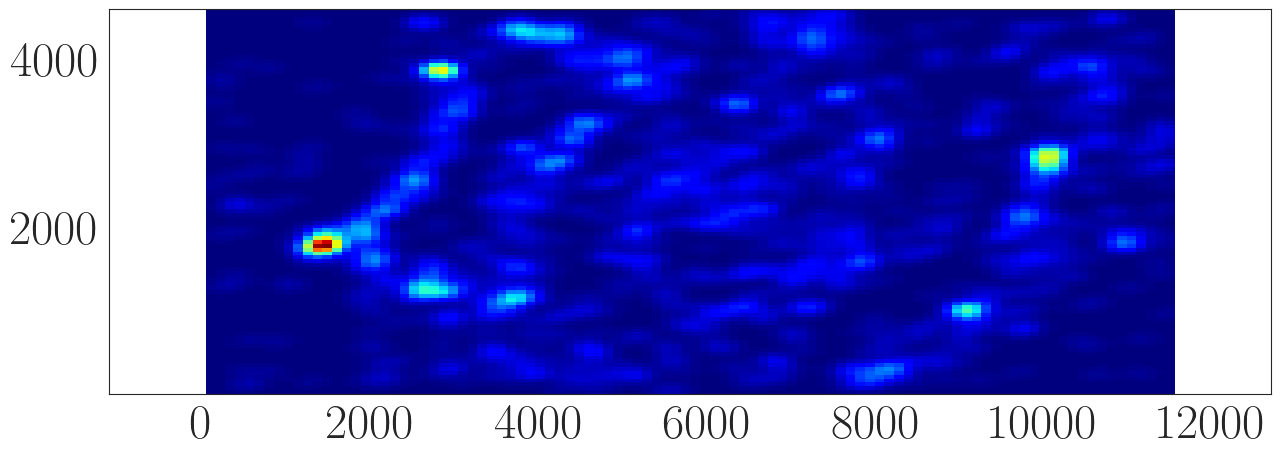

In [26]:
xx, yy = np.mgrid[x.min():x.max():100j,
                  y.min():y.max():100j]


positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])

kernel = gaussian_kde(values, bw_method=0.05)
f = np.reshape(kernel(positions), xx.shape)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()

ax.imshow(f.T, cmap='jet', extent=(x.min(),x.max(), y.min(),y.max()),
          interpolation='nearest', aspect='auto')
ax.axis('equal')

In [7]:
f115w_m50 = np.load("../SFH/ngc628/F115W_m50.npy")
f150w_m50 = np.load("../SFH/ngc628/F150W_m50.npy")
f200w_m50 = np.load("../SFH/ngc628/F200W_m50.npy")

f115w_a = np.load("../SFH/ngc628/F115W_a.npy")
f150w_a = np.load("../SFH/ngc628/F150W_a.npy")
f200w_a = np.load("../SFH/ngc628/F200W_a.npy")

Text(0, 0.5, 'y')

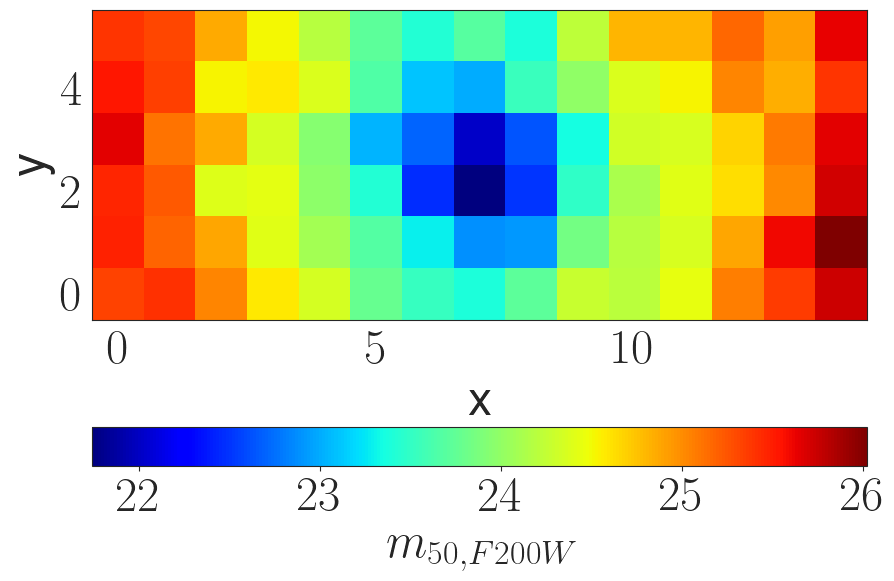

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
img = ax.imshow(f200w_m50.T, cmap='jet')
cb = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.2)
cb.set_label('$m_{50,F200W}$')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [37]:
tab = Table.read('../photometry/ngc628/f115w_f150w_f200w_photometry.fits')

for key, data in bubbles.items():
    ra_cen = data['ra']
    dec_cen = data['dec']

    filters = {'filt1':'f115w',
               'filt2':'f200w',
               'filt3':'f200w'}

    positions = {'ra_col': 'ra',
                 'dec_col' : 'dec',
                 'ra_cen': ra_cen,
                 'dec_cen': dec_cen}

    region = {'r_in':0,
              'r_out':data['radius'],
              'spatial_filter': 'circle'}

    extinction = {'Av': 0.19,
                  'Av_x': 2,
                  'Av_y': 26,
                  'Av_': 1}

    axis_limits= {'xlims': [-0.5, 5], 
                  'ylims': [17, 28]}

    isochrone_params={'met': [0.02],
                      'label_min': 0,
                      'label_max': 10,
                      'ages': [6.8,7,7.2,7.4,7.6,7.8,8]}

    error_settings = {'ref_xpos': -0.25,
                      'mag_err_lim':0.2}

    plot_settings = {'s':1, 'legend.ncols':1, 'alpha':0.6}

    fig,ax, tab1 = gen_CMD(tab, 
                          df_cmd_jwst,
                          filters, 
                          positions,
                          region,
                          extinction,
                          29.81,
                          axis_limits,
                          isochrone_params,
                          plot_settings=plot_settings,
                          error_settings=error_settings,
                          other_settings={'ab_dist': False, 'skip_data': False})
    
    ax.set_title(f"""{key} | Radius : {data['radius']}" | Count : {len(tab1)}""")
    fig.savefig(f'../CMDs/ngc628/JWST/{key}.png', bbox_inches='tight')
    
    plt.close(fig)

In [38]:
tab = Table.read('../photometry/ngc628/f435w_f555w_f814w_photometry.fits')


In [44]:
(tab['x'].max()-tab['x'].min())

9539.76

In [45]:
9539.76/20

476.988

In [43]:
np.sqrt(2)*500

707.1067811865476

In [47]:
 (tab['y'].max()-tab['y'].min())/20

392.2045

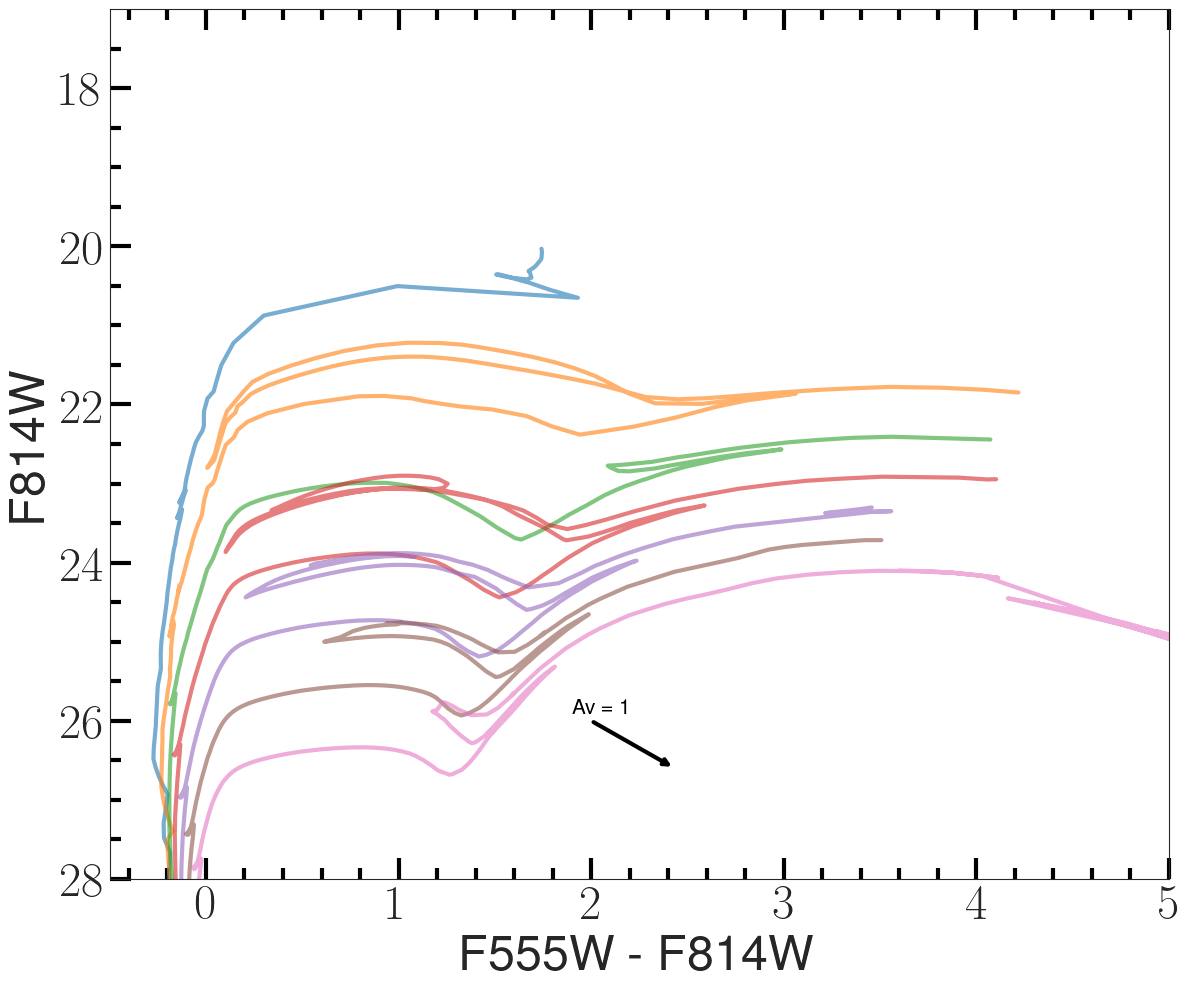

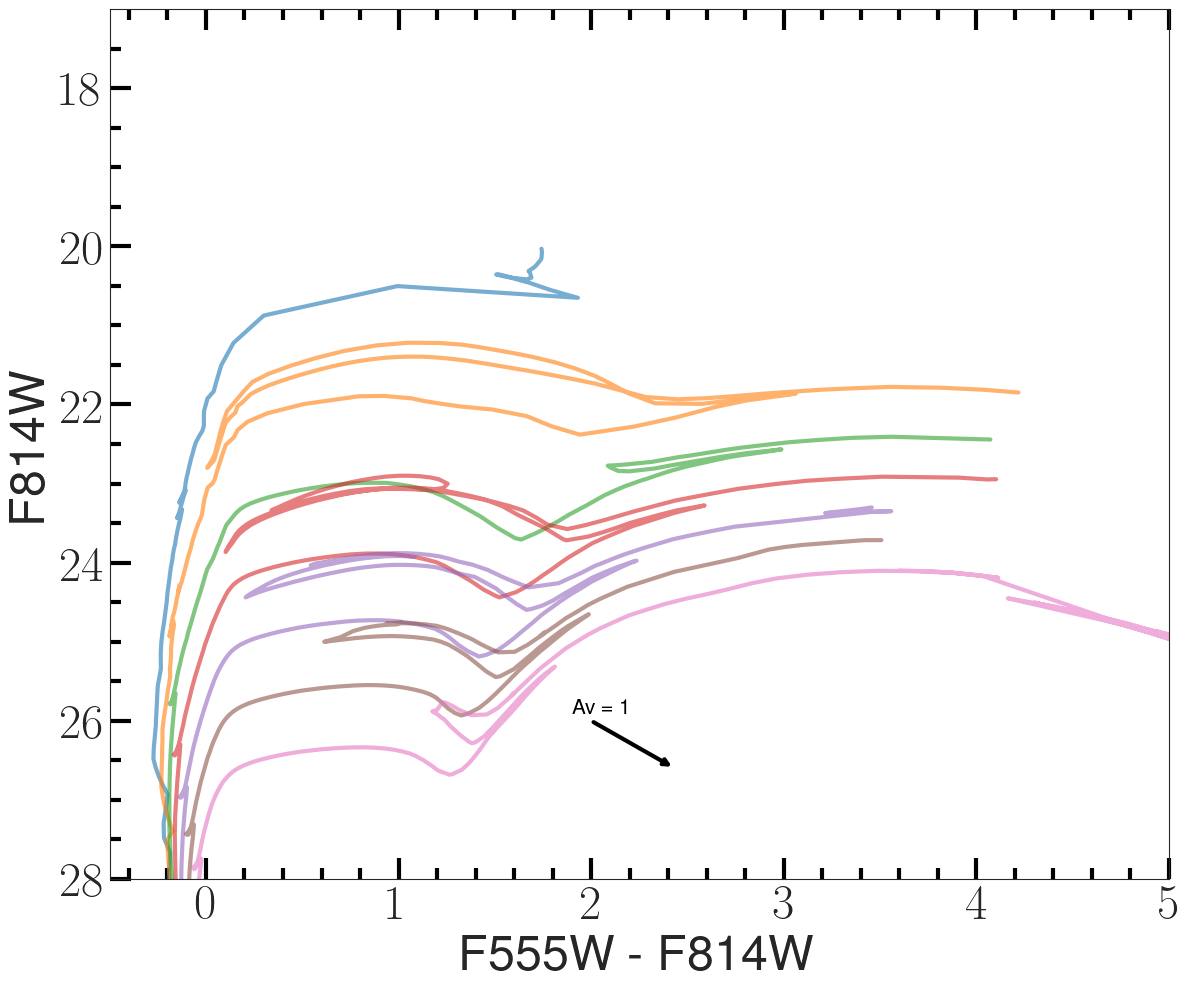

In [36]:
tab = Table.read('../photometry/ngc628/f435w_f555w_f814w_photometry.fits')

for key, data in bubbles.items():
    ra_cen = data['ra']
    dec_cen = data['dec']

    filters = {'filt1':'f555w',
               'filt2':'f814w',
               'filt3':'f814w'}

    positions = {'ra_col': 'ra',
                 'dec_col' : 'dec',
                 'ra_cen': ra_cen,
                 'dec_cen': dec_cen}

    region = {'r_in':0,
              'r_out':data['radius'],
              'spatial_filter': 'circle'}

    extinction = {'Av': 0.19,
                  'Av_x': 2,
                  'Av_y': 26,
                  'Av_': 1}

    axis_limits= {'xlims': [-0.5, 5], 
                  'ylims': [17, 28]}

    isochrone_params={'met': [0.02],
                      'label_min': 0,
                      'label_max': 10,
                      'ages': [6.8,7,7.2,7.4,7.6,7.8,8]}

    error_settings = {'ref_xpos': -0.25,
                      'mag_err_lim':0.2}

    plot_settings = {'s':1, 'legend.ncols':1, 'alpha':0.6}
    
    try:
        fig,ax, tab1 = gen_CMD(tab, 
                              df_cmd_acs,
                              filters, 
                              positions,
                              region,
                              extinction,
                              29.81,
                              axis_limits,
                              isochrone_params,
                              plot_settings=plot_settings,
                              error_settings=error_settings,
                              other_settings={'ab_dist': False, 'skip_data': False})

        ax.set_title(f"""{key} | Radius : {data['radius']}" | Count : {len(tab1)}""")
        fig.savefig(f'../CMDs/ngc628/HST/{key}.png', bbox_inches='tight')

        plt.close(fig)
    except:
        pass

In [33]:
ls ../catalogs

In [37]:
tab1.write('../catalogs/NGC628_BSGs.fits')

## **M51**

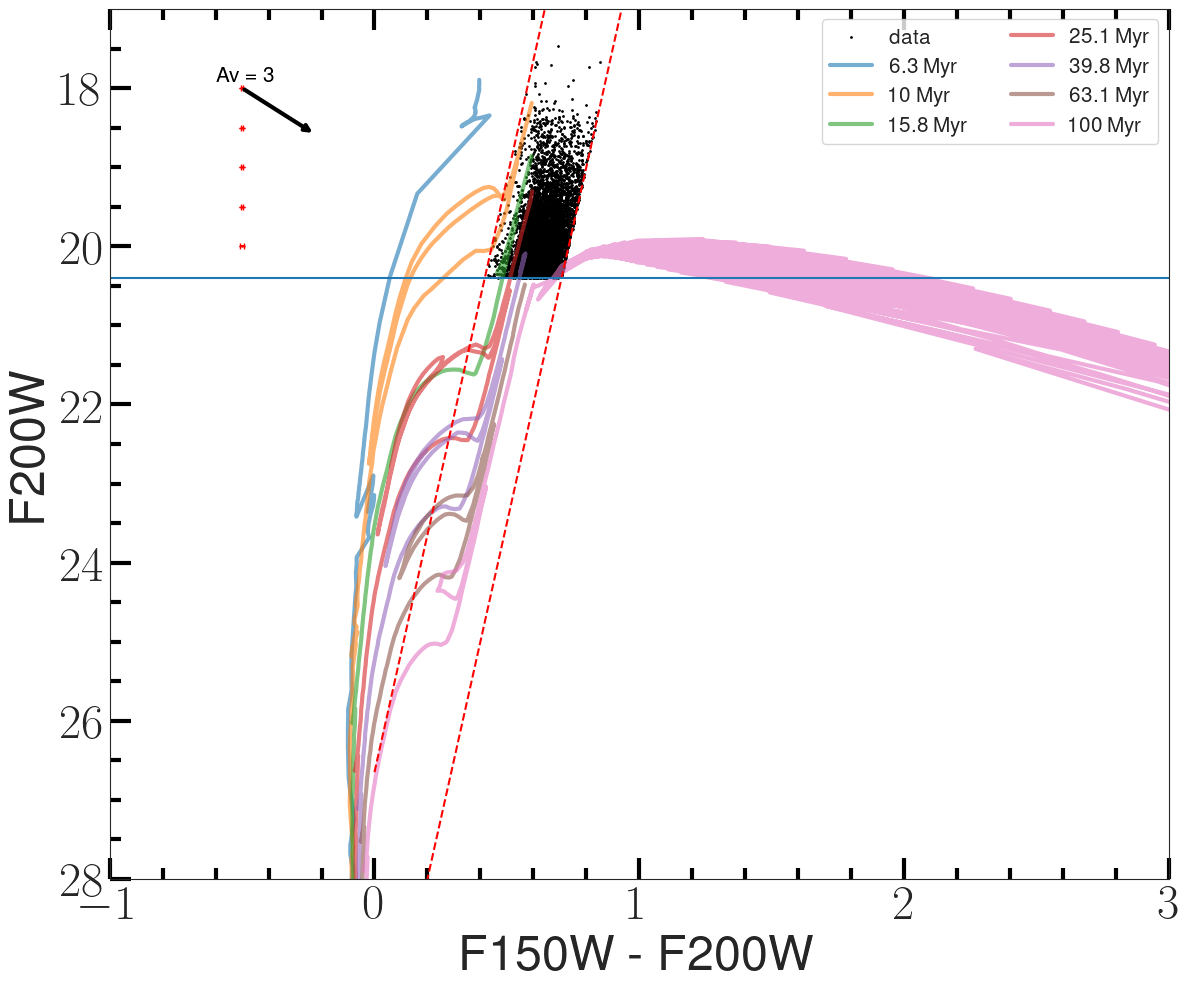

In [18]:
tab = Table.read('../photometry/m51/f115w_f150w_f200w_photometry.fits')

tab1 = tab.copy()

tab1['col'] = tab1["mag_vega_F150W"] -  tab1["mag_vega_F200W"]

tab1 = tab1[-15*(tab1['col']-0.51) + 19<=tab1["mag_vega_F200W"]]

tab1 = tab1[-15*(tab1['col']-0.8) + 19>=tab1["mag_vega_F200W"]]

tab1 = tab1[tab1["mag_vega_F200W"]<=20.4]

ra_cen = regions_dict['m51']['ra']
dec_cen = regions_dict['m51']['dec']

filters = {'filt1':'f150w',
           'filt2':'f200w',
           'filt3':'f200w'}

positions = {'ra_col': 'ra',
             'dec_col' : 'dec',
             'ra_cen': ra_cen,
             'dec_cen': dec_cen}

isochrone_params={'met': [0.02],
                  'label_min': 0,
                  'label_max': 10,
                  'ages': [6.8,7,7.2,7.4,7.6,7.8,8]}


region = {'r_in':0,
          'r_out': 2000,#:data['radius'],
          'spatial_filter': 'circle'}

error_settings = {'ref_xpos': -0.5,
                  'mag_err_lim':0.2}

plot_settings = {'s':1, 'legend.ncols':2, 'alpha':0.6}


axis_limits= {'xlims': [-1, 3], 
              'ylims': [17, 28]}

extinction = {'Av': 0.095,
              'Av_x': -0.5,
              'Av_y': 18,
              'Av_': 3}


plot_settings = {'s':1, 'legend.ncols':2, 'alpha':0.6}

fig,ax, tab2 = gen_CMD(tab1, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.67,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': False})

x = np.linspace(0,1)
y = -15*(x-0.51) + 19

ax.plot(x,y,'--r')

x = np.linspace(0,1)
y = -15*(x-0.8) + 19

ax.plot(x,y,'--r')

ax.axhline(20.4)

In [42]:
ra_cen, dec_cen

(202.4357175, 9.863)

In [48]:
tab = Table.read('../photometry/m51/f115w_f150w_f200w_photometry.fits')

for key, data in m51_bubbles.items():
    ra_cen = data['ra']
    dec_cen = data['dec']

    filters = {'filt1':'f115w',
               'filt2':'f200w',
               'filt3':'f200w'}

    positions = {'ra_col': 'ra',
                 'dec_col' : 'dec',
                 'ra_cen': ra_cen,
                 'dec_cen': dec_cen}

    region = {'a1': 0,
              'b1': 0,
              'a2': data['a'],
              'b2': data['b'],
              'ang': data['ang'],
              'spatial_filter': 'ellipse'}

    extinction = {'Av': 0.095,
                  'Av_x': -0.5,
                  'Av_y': 18,
                  'Av_': 3}


    axis_limits= {'xlims': [-1, 3], 
                  'ylims': [17, 28]}

    isochrone_params={'met': [0.02],
                      'label_min': 0,
                      'label_max': 10,
                      'ages': [6.8,7,7.2,7.4,7.6,7.8,8]}

    error_settings = {'ref_xpos': -0.25,
                      'mag_err_lim':0.2}

    plot_settings = {'s':1, 'legend.ncols':1, 'alpha':0.6}

    fig,ax, tab1 = gen_CMD(tab, 
                          df_cmd_jwst,
                          filters, 
                          positions,
                          region,
                          extinction,
                          29.67,
                          axis_limits,
                          isochrone_params,
                          plot_settings=plot_settings,
                          error_settings=error_settings,
                          other_settings={'ab_dist': False, 'skip_data': False})
    
    ax.set_title(f"""{key} | Radius : {np.round(np.sqrt(data['a']*data['b']),2)}" | Count : {len(tab1)}""")
    fig.savefig(f'../CMDs/m51/JWST/{key}.png', bbox_inches='tight')
    
    plt.close(fig)

/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 4294


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 498


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 4008


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 1603


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 809


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 1763


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 552


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 1214


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 521


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 3373


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 2428


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 4193


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 510


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 810


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 4841


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 1525


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 7487


/mnt/d/Code_Stuff/INAOE/Bubble/notebooks/catalog_filter.py:90: RuntimeWarning: divide by zero encountered in divide
  mask = (rotated_offsets[0]**2/a1**2 + rotated_offsets[1]**2/b1**2  >= 1)


Number of objects in the selected region: 741


In [17]:
tab1.write("../catalogs/m51/RSGs.fits", overwrite=True)